___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />

# Microestructuras y Sistema de Trading
## Laboratorio 1

### EQUIPO:
#### - Tere Castillo
#### - Ana Laura Correa
#### - Gaspar Benitez
#### - Marysol Cantarero

#### Situación: 
Acabas de entrar a trabajar a una operadora de fondos de inversión como analista financiero dentro de la mesa de análisis del mercado de renta variable. En la junta trimestral se plantea la posibilidad de crear un fondo propio con exposición al mercado de valores de USA tratando de replicar a los ETFs conocidos como ishares que la empresa BlackRock ofrece. 

La idea es replicar un ETF con posiciones en directo. Te han asignado la tarea de hacer un ejercicio simple de replicar la construcción de un portafolio de inversión y un criterio de rebalanceo lo más parecido a un ETF de ishares que tu selecciones. Esto con la finalidad de comparar los resultados de haber rebalanceado periódicamente el portafolio, ó, no haberlo hecho y continuar todo un año con las mismas posiciones.


#### Resolucion del problema

Los ETF(Exchange Trade Funds) son fondos o instrumentos de inversión cuyos títulos cotizan en la bolsa, al igual que una acción bursátil,pudiendose comprar y vender en cualquier momento, sin necesidad de esperar al cierre del mercado. Su objetivo es replicar el comportamiento de los activos que componen un índice bursátil, ya sea de renta fija, variable, divisas o materias primas u otros activos financieros.

Para este problema se analizara el ETF "iShares U.S. Financials ETF (IYF)" para el mercado de renta variable de USA con posiciones en directo tomando información del 01/Marzo/2018 al 01/Marzo/2019. Sin embargo, el código a realizar debe ser repetible para cualquier ETF.

Las 3 medidas de atribución al desempeño que se eligieron para la comparación de los resultados son: Rendimiento, volatilidad y medidas de desempeño.

#### Características mínimas de solución: 
Debido a tu formación, te piden que este proceso que construyas sea repetible para cualquier ETF y también incluir 3 medidas de atribución al desempeño, tanto para el caso que el ETF nunca hubiese sido rebalanceado como para los casos donde sí. 

En la mesa de análisis están interesados en conocer el proceso que sigues para adquirir, limpiar, dar formato y utilizar los datos, y a pesar que el equipo senior de análisis está compuesto por personal altamente calificado en temas de economía y finanzas, ellos no saben programar por lo que te piden que incluyas el código utilizado, y que sea de manera ordenada y explicando el sentido de las funciones y paqueterías que requeriste. 

Comparar con 1 año de información: 01/Marzo/2017 al 01/Marzo/2018 

Utilizar un ETF de Ishares para el mercado de renta varialbe de USA 

Entregar un Jupyter Notebook con explicación y comentarios en el código 

Crear y actualizar continuamente un repositorio en GitHub para el proyecto.

#### Resolucion del problema

Los ETF(Exchange Trade Funds) son fondos o instrumentos de inversión cuyos títulos cotizan en la bolsa, al igual que una acción bursátil,pudiendose comprar y vender en cualquier momento, sin necesidad de esperar al cierre del mercado. Su objetivo es replicar el comportamiento de los activos que componen un índice bursátil, ya sea de renta fija, variable, divisas o materias primas u otros activos financieros.

Para este problema se analizara el ETF "iShares U.S. Financials ETF (IYF)" para el mercado de renta variable de USA con posiciones en directo tomando información del 01/Marzo/2017 al 01/Marzo/2018. Sin embargo, el código a realizar debe ser repetible para cualquier ETF.

Las 3 medidas de atribución al desempeño que se eligieron para la comparación de los resultados son: Rendimiento, volatilidad y medidas de desempeño.

In [1]:
# Descarga de librerías
import quandl
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH"  # API key Quandl
narch = 13
fechas = list(['2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30',
                 '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30',
                 '2017-12-29', '2018-01-31', '2018-02-28'])
tl = [0.4, 0.74, 0.68, 0.86 , 0.84, 1, 0.95, 0.96, 0.99 , 1.14 ,0.28 , 1.43, 1.5]

### DESCARGA DE DATOS

In [3]:
# Función para descarga de archivos csv de holdings etf y sus tickers 
def holdings_csv(narch,name):
    holdings = []
    tickers = []
    shares = []
    for i in range(narch):
        r = name+str(i)+".csv"
        info = pd.read_csv(r,header=10, index_col= 0)
        shar = pd.read_csv(r,nrows=7).loc['Shares Outstanding'][0]
        info = info.dropna() # quitando los datos vacios.
        info = info.drop(columns = ['Name', 'Asset Class', "Market Value", 'Notional Value', 'Sector', 'SEDOL', 'ISIN', 'Exchange'])
        holdings.append(info)
        tickers.append(list(holdings[i].index))
        shares.append(shar)
    return holdings, tickers, shares
holdings, tickers, shares = holdings_csv(narch,"IYF_holdings")

In [4]:
# Función para descarga de datos históricos y agrupacion de tickers por fecha (QUANDL)
def download_quandl(fechas, tickers):
    date = {'gte': fechas[0], 'lte': fechas[-1] }
    column = {'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts=column, ticker=tickers, date=date, paginate=True)
    data = data.set_index('date')
    data = data.pivot(columns='ticker') # agrupacion de tickers por fecha 
    data.columns = data.columns.droplevel(0)
    return data

In [5]:
#Función para convertir de str a float.
def str_to_float(var):
    st=var
    if type(var[0]) != np.float64:
        st=[]
        for i in var:
            st.append(float(i.replace(',','')))
    return (st)

In [6]:
# Función para calcular el rendimiento de las series
def Rend(narch,name):
    h =[]
    for i in range(narch-1):
        y= np.log(name[i+1]/name[i])
        h.append(y)
    return h

In [7]:
#Función para calcular las medidas de desepeño ( Rendimiento, Variación y sharpe)
def medidas_desempeño(narch,Rend,tl):
    media = np.mean(Rend)
    std = np.std(Rend)
    sharpe = (media -tl[i])/std
    return media, std, sharpe

### LIMPIEZA DE INFORMACIÓN

In [8]:
# Juntando tickers para hacer un mismo indice
venta=[] 
igual=[] 
compra=[] 
for i in range(narch-1):
    venta.append(list(set(tickers[i])-set(tickers[i+1]))) # ya no estan, se vendieron.
    igual.append(list(set(tickers[i+1])-set((set(tickers[i+1])-set(tickers[i]))))) # las que permanecieron.
    compra.append(list(set(tickers[i+1])-set(tickers[i])))  # aparecieron, se compraron
venta = list(np.concatenate(venta))
igual = list(np.concatenate(igual))
compra = list(np.concatenate(compra))
indice = list(set(venta+igual+compra))

In [9]:
# Acomodo de información de acuerdo a índice(tickers) en común (Weight(%), Price y Shares)
Weights , Prices, Shares = pd.DataFrame(index=indice) , pd.DataFrame(index=indice), pd.DataFrame(index=indice)
for i in range(narch):
    l,l1,l2= [],[],[]
    for j in range(len(tickers[i])):
        l.append(holdings[i]['Weight (%)'][tickers[i][j]])
        l1.append(holdings[i]['Price'][tickers[i][j]])
        l2.append(holdings[i]['Shares'][tickers[i][j]])
    l , l1, l2 = pd.DataFrame(l, index=tickers[i]),pd.DataFrame(str_to_float(l1), index=tickers[i]),pd.DataFrame(str_to_float(l2), index=tickers[i])
    Weights['Holdings'+str(i)+''] ,Prices['Holdings'+str(i)+''],Shares['Holdings'+str(i)+''] = l ,l1 , l2

# ESCENARIOS REBALANCEOS

El primer escenario es igual al original para la comparación final, para los demás escenarios realizan distintos rebalanceos.

Por ejemplo(periodo rebalanceos): segundo escenario = [0], tercer escenario = [0,1] , cuarto escenario = [0,1] , ... , ultimo escenario = [0,11]

En el segundo escenario no hay rebalanceos, es decir, se mantienen las mismas posiciones durante todo el año.
Del tercer al ultimo escenario únicamente hay un rebalanceo mensual, el cual se va recorriendo mensualmente por escenario.

### ESCENARIO A -  ORIGINAL

In [10]:
def nav(narch):
    nav = []
    for i in range(narch):
        mult = Prices['Holdings'+str(i)+''].dropna() * Shares['Holdings'+str(i)+''].dropna()
        mult.loc['USD'] = mult.loc['USD']/100
        nav.append(sum(mult) / str_to_float(shares)[i])
    return nav
navA = nav(narch)
navA

[107.66478606632658,
 103.75565147341037,
 103.78729682901235,
 103.37776902738847,
 107.17077279021407,
 109.50167307784433,
 108.45363532186589,
 112.13038047386361,
 112.85907623999992,
 118.3854700424069,
 119.28937116196319,
 127.25094931379313,
 122.42896706809653]

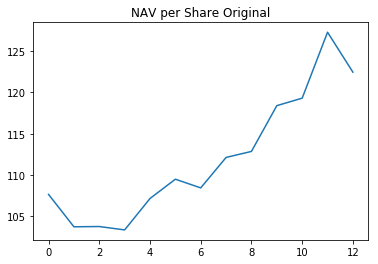

In [11]:
plt.plot(navA)
plt.title('NAV per Share Original')
plt.show()

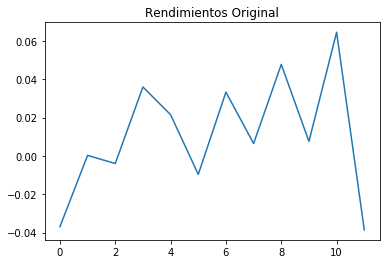

In [12]:
plt.plot(Rend(narch,navA))
plt.title('Rendimientos Original')
plt.show()

### ESCENARIO B - SIN REBALANCEOS

In [14]:
#descargando datos quandl y agrupando tickers por fecha.
prices = download_quandl(fechas, indice)
prices.head()

ConnectionError: HTTPSConnectionPool(host='www.quandl.com', port=443): Max retries exceeded with url: /api/v3/datatables/WIKI/PRICES?qopts.columns%5B%5D=ticker&qopts.columns%5B%5D=date&qopts.columns%5B%5D=Adj_close&ticker%5B%5D=SNH&ticker%5B%5D=SFR&ticker%5B%5D=O&ticker%5B%5D=FRC&ticker%5B%5D=FCEA&ticker%5B%5D=STT&ticker%5B%5D=CYS&ticker%5B%5D=JOE&ticker%5B%5D=UDR&ticker%5B%5D=AHL&ticker%5B%5D=PEB&ticker%5B%5D=FII&ticker%5B%5D=ISBC&ticker%5B%5D=SKT&ticker%5B%5D=BXP&ticker%5B%5D=SF&ticker%5B%5D=SNV&ticker%5B%5D=DEI&ticker%5B%5D=NHI&ticker%5B%5D=JPM&ticker%5B%5D=BDN&ticker%5B%5D=HCP&ticker%5B%5D=MTG&ticker%5B%5D=AXP&ticker%5B%5D=TROW&ticker%5B%5D=HTA&ticker%5B%5D=MAC&ticker%5B%5D=NYCB&ticker%5B%5D=RDN&ticker%5B%5D=WRB&ticker%5B%5D=ZION&ticker%5B%5D=HIG&ticker%5B%5D=GNW&ticker%5B%5D=MKTX&ticker%5B%5D=FNF&ticker%5B%5D=EQC&ticker%5B%5D=NAVI&ticker%5B%5D=PNFP&ticker%5B%5D=UNIT&ticker%5B%5D=GBCI&ticker%5B%5D=HBAN&ticker%5B%5D=TCF&ticker%5B%5D=EQIX&ticker%5B%5D=OUT&ticker%5B%5D=IRM&ticker%5B%5D=AMT&ticker%5B%5D=CFR&ticker%5B%5D=DDR&ticker%5B%5D=THG&ticker%5B%5D=WELL&ticker%5B%5D=CHFC&ticker%5B%5D=FCPT&ticker%5B%5D=LM&ticker%5B%5D=EWBC&ticker%5B%5D=SPGI&ticker%5B%5D=CATY&ticker%5B%5D=AGO&ticker%5B%5D=CXW&ticker%5B%5D=DRE&ticker%5B%5D=AMTD&ticker%5B%5D=LSI&ticker%5B%5D=BAC&ticker%5B%5D=CME&ticker%5B%5D=DFS&ticker%5B%5D=AIG&ticker%5B%5D=HOMB&ticker%5B%5D=PVTB&ticker%5B%5D=LAMR&ticker%5B%5D=LNC&ticker%5B%5D=UE&ticker%5B%5D=SYF&ticker%5B%5D=TCO&ticker%5B%5D=CBL&ticker%5B%5D=NTRS&ticker%5B%5D=WPC&ticker%5B%5D=PBCT&ticker%5B%5D=PACW&ticker%5B%5D=WTM&ticker%5B%5D=UMPQ&ticker%5B%5D=HBHC&ticker%5B%5D=FFIN&ticker%5B%5D=EQY&ticker%5B%5D=GPT&ticker%5B%5D=PRAA&ticker%5B%5D=KEY&ticker%5B%5D=WBS&ticker%5B%5D=PLD&ticker%5B%5D=CFFN&ticker%5B%5D=ICE&ticker%5B%5D=GS&ticker%5B%5D=JLL&ticker%5B%5D=STI&ticker%5B%5D=BGCP&ticker%5B%5D=MTB&ticker%5B%5D=CUBE&ticker%5B%5D=CFG&ticker%5B%5D=HCN&ticker%5B%5D=CUZ&ticker%5B%5D=ALL&ticker%5B%5D=WFC&ticker%5B%5D=CMA&ticker%5B%5D=VOYA&ticker%5B%5D=IBKC&ticker%5B%5D=IBOC&ticker%5B%5D=AWH&ticker%5B%5D=WTFC&ticker%5B%5D=OHI&ticker%5B%5D=WPG&ticker%5B%5D=L&ticker%5B%5D=SBRA&ticker%5B%5D=ACC&ticker%5B%5D=SLG&ticker%5B%5D=PK&ticker%5B%5D=PB&ticker%5B%5D=DOC&ticker%5B%5D=FCNCA&ticker%5B%5D=RE&ticker%5B%5D=VER&ticker%5B%5D=UNM&ticker%5B%5D=CNO&ticker%5B%5D=RYN&ticker%5B%5D=PNC&ticker%5B%5D=PGRE&ticker%5B%5D=DRH&ticker%5B%5D=AFG&ticker%5B%5D=MMC&ticker%5B%5D=WU&ticker%5B%5D=ALLY&ticker%5B%5D=PCH&ticker%5B%5D=EPR&ticker%5B%5D=SIVB&ticker%5B%5D=FR&ticker%5B%5D=LAZ&ticker%5B%5D=V&ticker%5B%5D=CBSH&ticker%5B%5D=WRE&ticker%5B%5D=AFSI&ticker%5B%5D=JNS&ticker%5B%5D=BOKF&ticker%5B%5D=RNR&ticker%5B%5D=SLM&ticker%5B%5D=AMG&ticker%5B%5D=STL&ticker%5B%5D=IVR&ticker%5B%5D=BRO&ticker%5B%5D=WLTW&ticker%5B%5D=CINF&ticker%5B%5D=AKR&ticker%5B%5D=ATH&ticker%5B%5D=OZRK&ticker%5B%5D=COF&ticker%5B%5D=PSA&ticker%5B%5D=FAF&ticker%5B%5D=QCP&ticker%5B%5D=BXS&ticker%5B%5D=VNO&ticker%5B%5D=BLK&ticker%5B%5D=DCT&ticker%5B%5D=AIV&ticker%5B%5D=RF&ticker%5B%5D=USD&ticker%5B%5D=CLI&ticker%5B%5D=EVR&ticker%5B%5D=SEIC&ticker%5B%5D=CCI&ticker%5B%5D=EDR&ticker%5B%5D=TMK&ticker%5B%5D=HPP&ticker%5B%5D=ESS&ticker%5B%5D=BHF&ticker%5B%5D=OFC&ticker%5B%5D=DFT&ticker%5B%5D=STOR&ticker%5B%5D=BPOP&ticker%5B%5D=AVB&ticker%5B%5D=NNN&ticker%5B%5D=AFL&ticker%5B%5D=AIZ&ticker%5B%5D=CXP&ticker%5B%5D=BRX&ticker%5B%5D=RGA&ticker%5B%5D=AXS&ticker%5B%5D=MBFI&ticker%5B%5D=AJG&ticker%5B%5D=RLJ&ticker%5B%5D=TRV&ticker%5B%5D=AMH&ticker%5B%5D=WAL&ticker%5B%5D=GLPI&ticker%5B%5D=SBNY&ticker%5B%5D=FITB&ticker%5B%5D=CIT&ticker%5B%5D=DLR&ticker%5B%5D=MET&ticker%5B%5D=MSCI&ticker%5B%5D=FHN&ticker%5B%5D=FDS&ticker%5B%5D=ESNT&ticker%5B%5D=C&ticker%5B%5D=AGNC&ticker%5B%5D=VTR&ticker%5B%5D=VR&ticker%5B%5D=AON&ticker%5B%5D=HST&ticker%5B%5D=XL&ticker%5B%5D=XHR&ticker%5B%5D=PRI&ticker%5B%5D=PRA&ticker%5B%5D=REG&ticker%5B%5D=SRC&ticker%5B%5D=CB&ticker%5B%5D=AMP&ticker%5B%5D=ERIE&ticker%5B%5D=ELS&ticker%5B%5D=WAFD&ticker%5B%5D=BEN&ticker%5B%5D=PKY&ticker%5B%5D=COR&ticker%5B%5D=CBOE&ticker%5B%5D=USB&ticker%5B%5D=MAA&ticker%5B%5D=EV&ticker%5B%5D=LHO&ticker%5B%5D=SHO&ticker%5B%5D=CBG&ticker%5B%5D=HHC&ticker%5B%5D=UBSI&ticker%5B%5D=RHP&ticker%5B%5D=MA&ticker%5B%5D=MS&ticker%5B%5D=IVZ&ticker%5B%5D=MCO&ticker%5B%5D=ARE&ticker%5B%5D=EXR&ticker%5B%5D=STWD&ticker%5B%5D=TCB&ticker%5B%5D=CCP&ticker%5B%5D=FRT&ticker%5B%5D=RJF&ticker%5B%5D=FNGN&ticker%5B%5D=EGP&ticker%5B%5D=ETFC&ticker%5B%5D=Y&ticker%5B%5D=SPG&ticker%5B%5D=ORI&ticker%5B%5D=WDR&ticker%5B%5D=ENH&ticker%5B%5D=WY&ticker%5B%5D=KIM&ticker%5B%5D=RPAI&ticker%5B%5D=CONE&ticker%5B%5D=MFA&ticker%5B%5D=GEO&ticker%5B%5D=APLE&ticker%5B%5D=BBT&ticker%5B%5D=CLNS&ticker%5B%5D=ASB&ticker%5B%5D=LPT&ticker%5B%5D=BK&ticker%5B%5D=PGR&ticker%5B%5D=KMPR&ticker%5B%5D=NDAQ&ticker%5B%5D=JHG&ticker%5B%5D=WRI&ticker%5B%5D=PDM&ticker%5B%5D=JBGS&ticker%5B%5D=UMBF&ticker%5B%5D=HR&ticker%5B%5D=BOH&ticker%5B%5D=TWO&ticker%5B%5D=CPT&ticker%5B%5D=CACC&ticker%5B%5D=NRZ&ticker%5B%5D=MPW&ticker%5B%5D=SBAC&ticker%5B%5D=PRU&ticker%5B%5D=DFIN&ticker%5B%5D=MKL&ticker%5B%5D=FULT&ticker%5B%5D=BKU&ticker%5B%5D=RLGY&ticker%5B%5D=TCBI&ticker%5B%5D=RLI&ticker%5B%5D=HPT&ticker%5B%5D=KRC&ticker%5B%5D=SCHW&ticker%5B%5D=CIM&ticker%5B%5D=KRG&ticker%5B%5D=HIW&ticker%5B%5D=BLKFDS&ticker%5B%5D=TRMK&ticker%5B%5D=LPLA&ticker%5B%5D=FNB&ticker%5B%5D=BXMT&ticker%5B%5D=NLY&ticker%5B%5D=LXP&ticker%5B%5D=BRKB&ticker%5B%5D=ACGL&ticker%5B%5D=SUI&ticker%5B%5D=GGP&ticker%5B%5D=VLY&ticker%5B%5D=LC&ticker%5B%5D=MCY&ticker%5B%5D=ALEX&ticker%5B%5D=EQR&ticker%5B%5D=PFG&date.gte=2017-02-28&date.lte=2018-02-28 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x00000157221976A0>: Failed to establish a new connection: [WinError 10060] Se produjo un error durante el intento de conexión ya que la parte conectada no respondió adecuadamente tras un periodo de tiempo, o bien se produjo un error en la conexión establecida ya que el host conectado no ha podido responder'))

In [ ]:
todo = []
for i in range(narch):
    prueba = pd.DataFrame(index=fechas)
    for j in tickers[i]:  
        if j in prices.columns:
            x = pd.DataFrame([prices[j].loc[fechas[z]] for z in range(len(fechas))],index=fechas)
            prueba[str(j)] = x
        else:
            x = list(Prices.loc[j])
            prueba[str(j)] = x
    todo.append(prueba.T)

In [ ]:
todo[0]

In [ ]:
xx

In [ ]:
todo = []
for i in range(narch):
    prueba = pd.DataFrame(index=fechas)
    for j in tickers[i]:  
        if j in prices.columns:
            for z in range(len(fechas)): 
                x= prices[j].loc[fechas[z]
                if x.isna():
                    x=list(Prices.loc[j])
                x.append(y)
            prueba[str(j)] = x
        else:
            x = list(Prices.loc[j])
            prueba[str(j)] = x
    todo.append(prueba.T)

In [ ]:
def nav(narch):
    nav = []
    for i in range(narch):
        mult = Prices['Holdings'+str(i)+''].dropna() * Shares['Holdings'+str(i)+''].dropna()
        mult.loc['USD'] = mult.loc['USD']/100
        nav.append(sum(mult) / str_to_float(shares)[i])
    return nav
navA = nav(narch)
navA

# ESCENARIOS
NOTA: Lo unico que se moverá son los pesos de rebalanceo. price y shares quedan igual.

In [ ]:
ind_qdl = [list(prices.columns)[i] for i in range(len(prices.columns))]
ind = list(set(indice)-set(ind_qdl))  # los que no estan en quandl

In [ ]:
holdings[0].loc['SRC']

In [ ]:
for i in range(narch):
    

De los 306 activos,  se encontraron 268. Esto quiere decir que no estan los datos de 38 activos.

Para los faltantes se utilizaran los mismos datos de los precios mensuales durante todos los días.

In [ ]:
v_etf = v_etf(narch) # Valor Total ETF con rebalanceos
v_etf

### ESCENARIOS : DISTINTOS REBALANCEOS
### CRITERIO DE RE BALANCEO.

In [ ]:
# FUNCIÓN PARA AJUSTE PESOS DE REBALANCEOS
def v_etf2(narch,preb):
    v_etf2 = []
    for i in range(preb):
        H = 'Holdings'+str(i)+''
        P,S = str_to_float(Prices[H]) , str_to_float(Shares[H])  
        a1 = Weights['Holdings0']*P*S
        v_etf1 = sum(a1)
        v_etf2.append(v_etf1)
    for i in range(narch-preb):
        H = 'Holdings'+str(i)+''
        P,S = str_to_float(Prices[H]) , str_to_float(Shares[H])
        a1 = Weights['Holdings'+str(preb)+'']*P*S
        v_etf1 = sum(a1)
        v_etf2.append(v_etf1)    
    return(v_etf2)

In [ ]:
v_etf2(narch,0)

In [ ]:
# FUNCIÓN PARA AJUSTE PESOS DE REBALANCEOS
def v_etf2(narch,preb):
    v_etf2 = []
    for i in range(preb):
        H = 'Holdings'+str(i)+''
        P,S = str_to_float(Prices[H]) , str_to_float(Shares[H])  
        a1 = Weights['Holdings0']*P*S
        v_etf1 = sum(a1)
        v_etf2.append(v_etf1)
    for i in range(narch-preb):
        H = 'Holdings'+str(i)+''
        P,S = str_to_float(Prices[H]) , str_to_float(Shares[H])
        a1 = Weights['Holdings'+str(preb)+'']*P*S
        v_etf1 = sum(a1)
        v_etf2.append(v_etf1)    
    return(v_etf2)

In [ ]:
REBcomp = pd.DataFrame()
for i in range(narch):
    REBcomp['REBp'+str(i)+''] = v_etf2(narch,i)
REBcomp

In [ ]:
Idx = REBcomp.columns
for i in range(len(Idx)):
    plt.plot(REBcomp['REBp'+str(i)+''], label = Idx[i]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
def medidas_desempeño(narch,name,tl):
    h =[]
    for i in range(narch-1):
        y= np.log(name[i+1]/name[i])
        h.append(y)
    media = np.mean(h)
    std = np.std(h)
    sharpe = (media -tl)/std
    return media, std, sharpe

In [ ]:
h = pd.DataFrame(index=['Rendimiento','Volatilidad','Sharpe'])
tl = [0.4, 0.74, 0.68, 0.86 , 0.84, 1, 0.95, 0.96, 0.99 , 1.14 ,0.28 , 1.43, 1.5]
for i in range(narch):
        nomp = 'REBp'+str(i)+''
        h[nomp] = medidas_desempeño(narch,REBcomp[nomp],tl[i]/100)
h = h.T
h

In [ ]:
#Idx = h.columns
#for i in range(len(Idx)):
#    plt.plot(h[h.columns[i]], label = Idx[i]) 
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.show()

### VALOR NAV (Net Asset Value) o VL(Valor liquidativo)
La rentabilidad pasada no es indicativa de la rentabilidad futura y no debe ser el único factor que se considere a la hora de seleccionar un producto. Los datos de rentabilidad se basan en el valor liquidativo (Net Asset Value, NAV) del ETF que puede no ser el mismo que el precio de mercado del ETF. Los accionistas individuales pueden obtener rendimientos distintos de la rentabilidad del NAV.


VL = P / N = Patrimonio neto del fondo(Valor de la Cartera del fondo) / Número de participaciones del fondo.

*El valor de la cartera de fondo es precios x shares.*
*El número de participaciones del fondo falta sacarlo.*

In [ ]:
nav_m = [info.loc[i]['NAV per Share'][0] for i in fechas]
shares_out = [info.loc[i]['Shares Outstanding'][0] for i in fechas]
info_m = pd.DataFrame(index=fechas)
info_m['NAV per Share'] = nav_m
info_m['Shares Outstanding'] = shares_out
info_m

In [ ]:
plt.plot(info_m['NAV per Share'])
plt.title('NAV per Share')
plt.show()

### COMPARACIÓN DE RESULTADOS: REBALANCEO VS. MISMAS POSICIONES

In [ ]:
# MEDIDAS DE ATRIBUCIÓN AL DESEMPEÑO

### CONCLUSIONES
.....

In [ ]:
# Función para descarga de datos históricos (QUANDL)
def download_quandl(fechas, narch):
    d2 = []  # Empty dictionary
    for i in range(narch):  # Loop to Download data from Quandl
        index= holdings[i].index
        q, h = holdings[i].shape
        ticker_r = list(index)  # ticker = 'WIKI/AAPL'
        date = {'gte': fechas[i], 'lte': fechas[i] }
        column = {'columns': ['ticker', 'date', 'Adj_close']}
        data = quandl.get_table('WIKI/PRICES', qopts=column, ticker=ticker_r, date=date)
        data = data.set_index('ticker')
        d2.append(data)
    return d2
prices = download_quandl(fechas,narch)
prices

In [ ]:
# LIMPIEZA DE DATOS 
def clean_data(narch, prices, holdings):
    d =[]
    hold = []
    for i in range(narch):
        a = set(list(prices[i].index))
        b = set(list(holdings[i].index))
        c = []
        for item in b:
            if item not in a:
                 c.append(item)
        d.append(c)
        holdi = holdings[i].drop(d[i]) # Se eliminan datos de ishares que no estan en quandl.
        hold.append(holdi)
    return hold
d = clean_data(narch, prices, holdings)
d

### BIBLIOGRAFÍA
https://www.portafolio.co/economia/finanzas/son-etf-293754

https://economipedia.com/definiciones/etf-fondos-cotizados.html

https://www.ishares.com/us/products/239508/#/

https://www.quandl.com/tools/python

